In [1]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    
    imax = len(p)
    jmax = np.size(p)//imax
    
    while tol > rtol:
        it += 1
        
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
        #this version is valid for dx!=dy
        p[1:-1, 1:-1] = 1.0/(2.0+2.0*(dx**2)/(dy**2))*(p_old[2:, 1:-1] + p_old[:-2, 1:-1] +
                                (p_old[1:-1, 2:] + p_old[1:-1,:-2])*(dx**2)/(dy**2)
                                - (dx**2)*RHS[1:-1, 1:-1])
        
        # apply zero gradient Neumann boundary conditions at the no slip walls
        p[:, 0] = p[:, 1]
        p[:, -1] = p[:, -2]
        p[-1, jmax//2:] = p[-2, jmax//2:]

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

In [3]:
def calculate_ppm_RHS_upwind(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use upwind differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] =rho*(np.select([u[1:-1, 1:-1] > 0, u[1:-1, 1:-1] < 0],
                      [np.diff(u[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u[1:, 1:-1], n=1, axis=0)/dx]) + 
              np.select([v[1:-1, 1:-1] > 0, v[1:-1, 1:-1] < 0],
                      [np.diff(v[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v[1:-1, 1:], n=1, axis=1)/dy]))
    return RHS

def calculate_ppm_RHS_central(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] = rho * (
        (1.0/dt) * ( (u[2:, 1:-1] - u[:-2, 1:-1]) / (2.0*dx) 
                   + (v[1:-1, 2:] - v[1:-1, :-2]) / (2.0*dy) ))
    return RHS

def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    u[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * (1./rho) * (
        (p[2:, 1:-1] - p[:-2, 1:-1])/(2*dx) )
    v[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * (1./rho) * (
        (p[1:-1, 2:] - p[1:-1, :-2])/(2*dy) )
    
    #apply the velocity boundary condition to the projected velocity data
    imax = len(u)
    jmax = np.size(u)//imax
    u[0,:] = u[1,:]
    u[-1,:-(jmax-jmax//2)] = u[-2,:-(jmax-jmax//2)]

    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    # intermediate u
    u[1:-1, 1:-1] = u_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uu_x + vu_x
                        u_old[1:-1, 1:-1] *
                      # see comments in the upwind based solver for advection above
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(u_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                         dt*nu*(np.diff(u_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(u_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    # intermediate v
    v[1:-1, 1:-1] = v_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uv_x + vv_x
                        u_old[1:-1, 1:-1] *
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(v_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                        dt*nu*(np.diff(v_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(v_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    
    return u, v

In [4]:
def update_concentrations(C, C_old, u, v, D, k, dx,dy,dt, logs = False):
    #update the interior points
    
    C[1:-1,1:-1] = C_old[1:-1,1:-1] + dt*(-k*C_old[1:-1,1:-1]
                                +D*(np.diff(C_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                + np.diff(C_old[1:-1, :], n=2, axis=1)/(dy**2))
                                -u[1:-1, 1:-1] *
                                    np.select([u[1:-1, 1:-1] > 0, u[1:-1, 1:-1] < 0],
                                    [np.diff(C_old[:-1, 1:-1], n=1, axis=0)/dx,
                                    np.diff(C_old[1:, 1:-1], n=1, axis=0)/dx]) -
                                 v[1:-1, 1:-1] *
                                    np.select([v[1:-1, 1:-1] > 0, v[1:-1, 1:-1] < 0],
                                      [np.diff(C_old[1:-1, :-1], n=1, axis=1)/dy,
                                       np.diff(C_old[1:-1, 1:], n=1, axis=1)/dy]))
    
    #solve the boundary conditions
    C[-1,:]=C[-2,:]
    C[:,0]=C[:,1]
    C[:,-1]=C[:,-2]
    
    return C

In [5]:
def solve_NS(u, v, C, p, rho, nu, D, k, courant, dt_min, t_end, dx, dy, rtol = 1.e-5, logs = False, outint = 100):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    C_old = C.copy()
    p_RHS = np.zeros_like(X)
    
    time_it = 0 
    
    while t < t_end:
        time_it+=1
        #set dt based on courant number
        vel_max = np.max(np.sqrt(u**2+v**2))
        if vel_max>0.0:
            dt = min(courant*min(dx,dy)/vel_max,dt_min)
            dt = min(courant*(min(dx,dy)**2)/(D*2.0), dt)
        else:
            dt = min(courant*(min(dx,dy)**2)/(D*2.0), dt_min)
        t += dt
        
        if logs and time_it%outint == 0:
            print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS_central(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs = (logs and time_it%outint == 0))
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        C = update_concentrations(C, C_old, u, v, D, k, dx,dy,dt, logs)
        
        if logs and time_it%outint == 0:
            imax = len(p)
            jmax = np.size(p)//imax
    
            C_out = np.average(u[-1,:jmax//2]*C[-1,:jmax//2])/np.average(u[-1,:jmax//2])

            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / min(dx,dy)))
            print('Average outlet concentration = ', C_out)
                
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
        temp = C_old
        C_old = C
        C = temp
        
    return u, v, p, C

In [6]:
# physical parameters
rho = 1000
nu = 1e-6
D = 1.e-6
k = 0.25

# define spatial mesh
# Size of rectangular domain
Lx = 0.05
Ly = 0.025

P_max = 0.5

C_0 = 1.0

# Reduced grid resolution
Nx = 51
Ny = 25

dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx * X
Y = dy * Y

# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)
C = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax
p[0, :] = P_max
p[-1, :-(jmax-jmax//2)-1] = 0.0

C[0, :] = C_0

#set a Courant number and use dynamic time step
courant = 0.1
dt_min = 1.e-3

t_end = 20

import time
start = time.time()
#u, v, p, C = solve_NS(u, v, C, p, rho, nu, D, k, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 1000)
end = time.time()
print('Time taken by calculation = ', end - start)

Time taken by calculation =  1.5974044799804688e-05


In [7]:
# Physical parameters
rho = 1000
C_0 = 1.0
courant = 0.1
dt_min = 1.e-3
t_end = 20

# Mesh
Lx = 0.05
Ly = 0.025
Nx = 51
Ny = 25
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx * X
Y = dy * Y



# Reduced parameter ranges (for a smaller set of simulations)
nu_values = [1e-6]
D_values = [1e-6, 2e-6, 3e-6, 4e-6]
k_values = [0.1]
P_max_values = [0.5]

# Results storage
results2 = []

# Simulation loop
for nu in nu_values:
    for D in D_values:
        for k in k_values:
            for P_max in P_max_values:
                # Initialize variables
                u = np.zeros_like(X)
                v = np.zeros_like(X)
                p = np.zeros_like(X)
                C = np.zeros_like(X)

                # Apply boundary conditions
                u[:, -1] = 0
                u[:, 0] = 0
                u[0, :] = 0
                u[-1, :] = 0
                v[:, -1] = 0
                v[:, 0] = 0
                v[0, :] = 0
                v[-1, :] = 0
                p[0, :] = P_max
                p[-1, :-(jmax-jmax//2)-1] = 0.0
                C[0, :] = C_0

                # Run simulation
                print(f"Running simulation for nu={nu}, D={D}, k={k}, P_max={P_max}")
                u, v, p, C = solve_NS(u, v, C, p, rho, nu, D, k, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs=False, outint=1000)

                # Calculate metrics
                avg_velocity = np.mean(np.sqrt(u[-1, :]**2 + v[-1, :]**2))
                C_out = np.mean(C[-1, :])  # Average outflow concentration

                # Store results, including fields
                results2.append({
                    'nu': nu,
                    'D': D,
                    'k': k,
                    'P_max': P_max,
                    'avg_velocity': avg_velocity,
                    'C_out': C_out,
                    'u': u,
                    'v': v,
                    'p': p,
                    'C': C,
                })

# Print results
for res in results2:
    print(f"nu={res['nu']}, D={res['D']}, k={res['k']}, P_max={res['P_max']}, "
          f"avg_velocity={res['avg_velocity']:.6f}, C_out={res['C_out']:.6f}")

Running simulation for nu=1e-06, D=1e-06, k=0.1, P_max=0.5
Running simulation for nu=1e-06, D=2e-06, k=0.1, P_max=0.5
Running simulation for nu=1e-06, D=3e-06, k=0.1, P_max=0.5
Running simulation for nu=1e-06, D=4e-06, k=0.1, P_max=0.5
nu=1e-06, D=1e-06, k=0.1, P_max=0.5, avg_velocity=0.011802, C_out=0.477067
nu=1e-06, D=2e-06, k=0.1, P_max=0.5, avg_velocity=0.011802, C_out=0.514908
nu=1e-06, D=3e-06, k=0.1, P_max=0.5, avg_velocity=0.011802, C_out=0.539521
nu=1e-06, D=4e-06, k=0.1, P_max=0.5, avg_velocity=0.011802, C_out=0.557428


In [25]:
# Physical parameters
rho = 1000
C_0 = 1.0
courant = 0.1
dt_min = 1.e-3
t_end = 20

# Mesh
Lx = 0.05
Ly = 0.025
Nx = 51
Ny = 25
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx * X
Y = dy * Y


#nu  k d P


# Reduced parameter ranges (for a smaller set of simulations)
nu_values = [1e-6, 2e-6]
D_values = [1e-6]
k_values = [0.1, 0.5]
P_max_values = [0.5, 1]


# Results storage
results1 = []

# Simulation loop
for nu in nu_values:
    for D in D_values:
        for k in k_values:
            for P_max in P_max_values:
                # Initialize variables
                u = np.zeros_like(X)
                v = np.zeros_like(X)
                p = np.zeros_like(X)
                C = np.zeros_like(X)

                # Apply boundary conditions
                u[:, -1] = 0
                u[:, 0] = 0
                u[0, :] = 0
                u[-1, :] = 0
                v[:, -1] = 0
                v[:, 0] = 0
                v[0, :] = 0
                v[-1, :] = 0
                p[0, :] = P_max
                p[-1, :-(jmax-jmax//2)-1] = 0.0
                C[0, :] = C_0

                # Run simulation
                print(f"Running simulation for nu={nu}, D={D}, k={k}, P_max={P_max}")
                u, v, p, C = solve_NS(u, v, C, p, rho, nu, D, k, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs=False, outint=1000)

                # Calculate metrics
                avg_velocity = np.mean(np.sqrt(u[-1, :]**2 + v[-1, :]**2))
                C_out = np.mean(C[-1, :])  # Average outflow concentration

                # Store results, including fields
                results1.append({
                    'nu': nu,
                    'D': D,
                    'k': k,
                    'P_max': P_max,
                    'avg_velocity': avg_velocity,
                    'C_out': C_out,
                    'u': u,
                    'v': v,
                    'p': p,
                    'C': C,
                })

# Print results
for res in results1:
    print(f"nu={res['nu']}, D={res['D']}, k={res['k']}, P_max={res['P_max']}, "
          f"avg_velocity={res['avg_velocity']:.6f}, C_out={res['C_out']:.6f}")

Running simulation for nu=1e-06, D=1e-06, k=0.1, P_max=0.5
Running simulation for nu=1e-06, D=1e-06, k=0.1, P_max=1
Running simulation for nu=1e-06, D=1e-06, k=0.5, P_max=0.5
Running simulation for nu=1e-06, D=1e-06, k=0.5, P_max=1
Running simulation for nu=2e-06, D=1e-06, k=0.1, P_max=0.5
Running simulation for nu=2e-06, D=1e-06, k=0.1, P_max=1
Running simulation for nu=2e-06, D=1e-06, k=0.5, P_max=0.5
Running simulation for nu=2e-06, D=1e-06, k=0.5, P_max=1
nu=1e-06, D=1e-06, k=0.1, P_max=0.5, avg_velocity=0.011802, C_out=0.477067
nu=1e-06, D=1e-06, k=0.1, P_max=1, avg_velocity=0.017476, C_out=0.551630
nu=1e-06, D=1e-06, k=0.5, P_max=0.5, avg_velocity=0.011802, C_out=0.110475
nu=1e-06, D=1e-06, k=0.5, P_max=1, avg_velocity=0.017476, C_out=0.182602
nu=2e-06, D=1e-06, k=0.1, P_max=0.5, avg_velocity=0.011382, C_out=0.460473
nu=2e-06, D=1e-06, k=0.1, P_max=1, avg_velocity=0.016857, C_out=0.538565
nu=2e-06, D=1e-06, k=0.5, P_max=0.5, avg_velocity=0.011382, C_out=0.102002
nu=2e-06, D=1e-06

In [18]:
# Physical parameters
rho = 1000
C_0 = 1.0
courant = 0.1
dt_min = 1.e-3
t_end = 20

# Mesh
Lx = 0.05
Ly = 0.025
Nx = 51
Ny = 25
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx * X
Y = dy * Y


#nu  k d P


# Reduced parameter ranges (for a smaller set of simulations)
nu_values = [1e-6]
D_values = [1e-6]
k_values = [0.1, 0.3, 0.5, 0.7]
P_max_values = [0.5]

# Results storage
results = []

# Simulation loop
for nu in nu_values:
    for D in D_values:
        for k in k_values:
            for P_max in P_max_values:
                # Initialize variables
                u = np.zeros_like(X)
                v = np.zeros_like(X)
                p = np.zeros_like(X)
                C = np.zeros_like(X)

                # Apply boundary conditions
                u[:, -1] = 0
                u[:, 0] = 0
                u[0, :] = 0
                u[-1, :] = 0
                v[:, -1] = 0
                v[:, 0] = 0
                v[0, :] = 0
                v[-1, :] = 0
                p[0, :] = P_max
                p[-1, :-(jmax-jmax//2)-1] = 0.0
                C[0, :] = C_0

                # Run simulation
                print(f"Running simulation for nu={nu}, D={D}, k={k}, P_max={P_max}")
                u, v, p, C = solve_NS(u, v, C, p, rho, nu, D, k, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs=False, outint=1000)

                # Calculate metrics
                avg_velocity = np.mean(np.sqrt(u[-1, :]**2 + v[-1, :]**2))
                C_out = np.mean(C[-1, :])  # Average outflow concentration

                # Store results, including fields
                results.append({
                    'nu': nu,
                    'D': D,
                    'k': k,
                    'P_max': P_max,
                    'avg_velocity': avg_velocity,
                    'C_out': C_out,
                    'u': u,
                    'v': v,
                    'p': p,
                    'C': C,
                })

# Print results
for res in results:
    print(f"nu={res['nu']}, D={res['D']}, k={res['k']}, P_max={res['P_max']}, "
          f"avg_velocity={res['avg_velocity']:.6f}, C_out={res['C_out']:.6f}")

Running simulation for nu=1e-06, D=1e-06, k=0.1, P_max=0.5
Running simulation for nu=1e-06, D=1e-06, k=0.3, P_max=0.5
Running simulation for nu=1e-06, D=1e-06, k=0.5, P_max=0.5
Running simulation for nu=1e-06, D=1e-06, k=0.7, P_max=0.5
nu=1e-06, D=1e-06, k=0.1, P_max=0.5, avg_velocity=0.011802, C_out=0.477067
nu=1e-06, D=1e-06, k=0.3, P_max=0.5, avg_velocity=0.011802, C_out=0.208984
nu=1e-06, D=1e-06, k=0.5, P_max=0.5, avg_velocity=0.011802, C_out=0.110475
nu=1e-06, D=1e-06, k=0.7, P_max=0.5, avg_velocity=0.011802, C_out=0.062254


In [36]:
import matplotlib.pyplot as plt

# Initialize lists for dimensionless numbers and metrics
Re_values = []
Pnd_values = []
Da_values = []
Eu_values = []
C_out_values = []
velocity_values = []

for res in results:
    avg_velocity = res['avg_velocity']
    L = Lx  # Characteristic length
    nu = res['nu']
    D = res['D']
    k = res['k']
    P_max = res['P_max']
    rho = 1000  # Fluid density
    C_out = res['C_out']

    # Calculate dimensionless numbers
    Re = avg_velocity * L / nu
    Pnd = (P_max * L**2) / (rho * nu**2)

    Da = k * L / avg_velocity if avg_velocity > 0 else 0.0
    Eu = P_max / (rho * avg_velocity**2) if avg_velocity > 0 else 0.0

    # Append to lists
    Re_values.append(Re)
    Pnd_values.append(Pnd)
    Da_values.append(Da)
    Eu_values.append(Eu)
    C_out_values.append(C_out)
    velocity_values.append(avg_velocity)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Initialize lists for dimensionless numbers and metrics
Re_values1 = []
Pnd_values1 = []

C_out_values1 = []
velocity_values = []

for res in results1:
    avg_velocity = res['avg_velocity']
    L = Lx  # Characteristic length
    nu = res['nu']
    D = res['D']
    k = res['k']
    P_max = res['P_max']
    rho = 1000  # Fluid density
    C_out = res['C_out']

    # Calculate dimensionless numbers
    Re = avg_velocity * L / nu
    Pnd = (P_max * L**2) / (rho * nu**2)

    Da = k * L / avg_velocity if avg_velocity > 0 else 0.0
    Eu = P_max / (rho * avg_velocity**2) if avg_velocity > 0 else 0.0

    # Append to lists
    Re_values1.append(Re)
    Pnd_values1.append(Pnd)
    
    C_out_values1.append(C_out)


import matplotlib.pyplot as plt



# Initialize lists for dimensionless numbers and metrics

Pe_values = []

C_out_values2 = []


for res in results2:
    avg_velocity = res['avg_velocity']
    L = Lx  # Characteristic length
    nu = res['nu']
    D = res['D']
    k = res['k']
    P_max = res['P_max']
    rho = 1000  # Fluid density
    C_out = res['C_out']

    # Calculate dimensionless numbers
   
    Pe = avg_velocity * L / D

    # Append to lists
    
    Pe_values.append(Pe)
    C_out_values2.append(C_out)

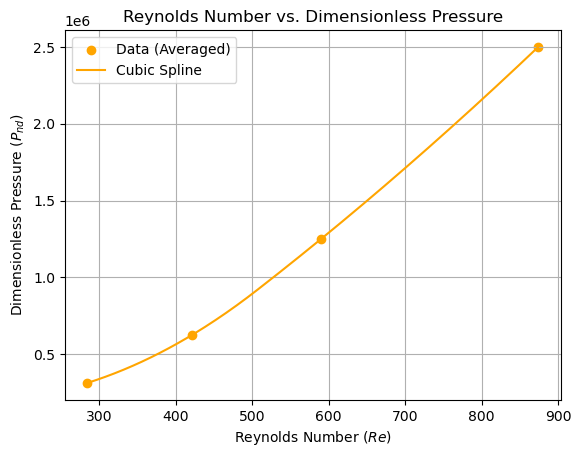

In [29]:
import numpy as np
from scipy.interpolate import make_interp_spline

# Sort data by Re_values
sorted_data = sorted(zip(Re_values1, Pnd_values1), key=lambda x: x[0])
Re_sorted, Pnd_sorted = zip(*sorted_data)
Re_sorted = np.array(Re_sorted)
Pnd_sorted = np.array(Pnd_sorted)

# 1. Identify unique x-values and their indices
unique_Re, indices = np.unique(Re_sorted, return_inverse=True)

# 2. For each unique Re, we average the corresponding Pnd values.
#    (You could also choose min, max, or something else.)
Pnd_averaged = np.zeros_like(unique_Re)
counts = np.zeros_like(unique_Re)

for i, idx in enumerate(indices):
    Pnd_averaged[idx] += Pnd_sorted[i]
    counts[idx] += 1

Pnd_averaged = Pnd_averaged / counts

# Now we have unique_Re and Pnd_averaged with no duplicates.
# 3. Use make_interp_spline on the cleaned data
spline = make_interp_spline(unique_Re, Pnd_averaged, k=2)

# 4. Interpolate on a fine grid
Re_fine = np.linspace(unique_Re.min(), unique_Re.max(), 300)
Pnd_smooth = spline(Re_fine)

# 5. Plot
fig, ax = plt.subplots()
ax.scatter(unique_Re, Pnd_averaged, c='orange', label='Data (Averaged)')
ax.plot(Re_fine, Pnd_smooth, c='orange', label='Cubic Spline')
ax.set_xlabel('Reynolds Number ($Re$)')
ax.set_ylabel('Dimensionless Pressure ($P_{nd}$)')
ax.set_title('Reynolds Number vs. Dimensionless Pressure')
ax.grid()
ax.legend()
plt.show()

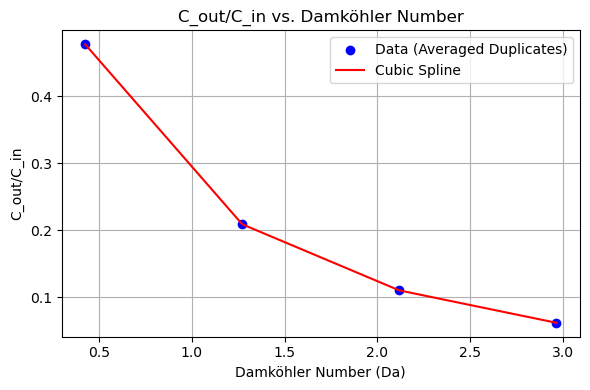

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


# 1. Sort data by Da_values
sorted_data = sorted(zip(Da_values, C_out_values), key=lambda x: x[0])
Da_sorted, C_out_sorted = zip(*sorted_data)

Da_sorted = np.array(Da_sorted)
C_out_sorted = np.array(C_out_sorted)

# 2. Remove duplicates in Da by AVERAGING the corresponding C_out
Da_unique, indices = np.unique(Da_sorted, return_inverse=True)

# Prepare arrays to accumulate sums and counts
C_out_averaged = np.zeros_like(Da_unique, dtype=float)
counts = np.zeros_like(Da_unique, dtype=float)

for i, idx in enumerate(indices):
    C_out_averaged[idx] += C_out_sorted[i]
    counts[idx] += 1

# Convert sums to averages
C_out_averaged = C_out_averaged / counts

# 3. Perform spline interpolation on the "clean" data
#    (Cubic spline by default with k=3)
spline = make_interp_spline(Da_unique, C_out_averaged, k=1)

# 4. Create a dense array of x-values for the smooth curve
Da_fine = np.linspace(Da_unique.min(), Da_unique.max(), 300)
C_out_smooth = spline(Da_fine)

# 5. Plot results
fig, ax = plt.subplots(figsize=(6, 4))

# Original (deduplicated/averaged) data
ax.scatter(Da_unique, C_out_averaged, color='blue', label='Data (Averaged Duplicates)')

# Smooth spline curve
ax.plot(Da_fine, C_out_smooth, color='red', label='Cubic Spline')

ax.set_xlabel('Damköhler Number (Da)')
ax.set_ylabel('C_out/C_in')
ax.set_title('C_out/C_in vs. Damköhler Number')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

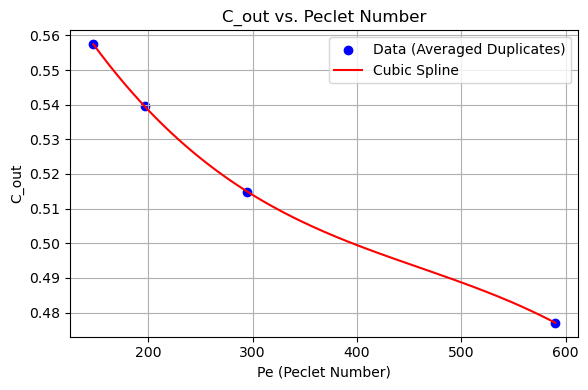

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline



# 1. Sort data by Pe_values
sorted_data = sorted(zip(Pe_values, C_out_values2), key=lambda x: x[0])
Pe_sorted, C_out_sorted = zip(*sorted_data)

Pe_sorted = np.array(Pe_sorted, dtype=float)
C_out_sorted = np.array(C_out_sorted, dtype=float)

# 2. Remove duplicates in Pe by AVERAGING the corresponding C_out
Pe_unique, indices = np.unique(Pe_sorted, return_inverse=True)

C_out_averaged = np.zeros_like(Pe_unique, dtype=float)
counts = np.zeros_like(Pe_unique, dtype=float)

# Sum values for duplicates
for i, idx in enumerate(indices):
    C_out_averaged[idx] += C_out_sorted[i]
    counts[idx] += 1

# Convert sums to averages
C_out_averaged = C_out_averaged / counts

# 3. Perform spline interpolation on the unique data
#    (Cubic spline by default with k=3)
spline = make_interp_spline(Pe_unique, C_out_averaged, k=3)

# 4. Create a dense array of x-values for the smooth curve
Pe_fine = np.linspace(Pe_unique.min(), Pe_unique.max(), 300)
C_out_smooth = spline(Pe_fine)

# 5. Plot results
fig, ax = plt.subplots(figsize=(6, 4))

# Original (deduplicated/averaged) data
ax.scatter(Pe_unique, C_out_averaged, color='blue', label='Data (Averaged Duplicates)')

# Smooth spline curve
ax.plot(Pe_fine, C_out_smooth, color='red', label='Cubic Spline')

ax.set_xlabel('Pe (Peclet Number)')
ax.set_ylabel('C_out')
ax.set_title('C_out vs. Peclet Number')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

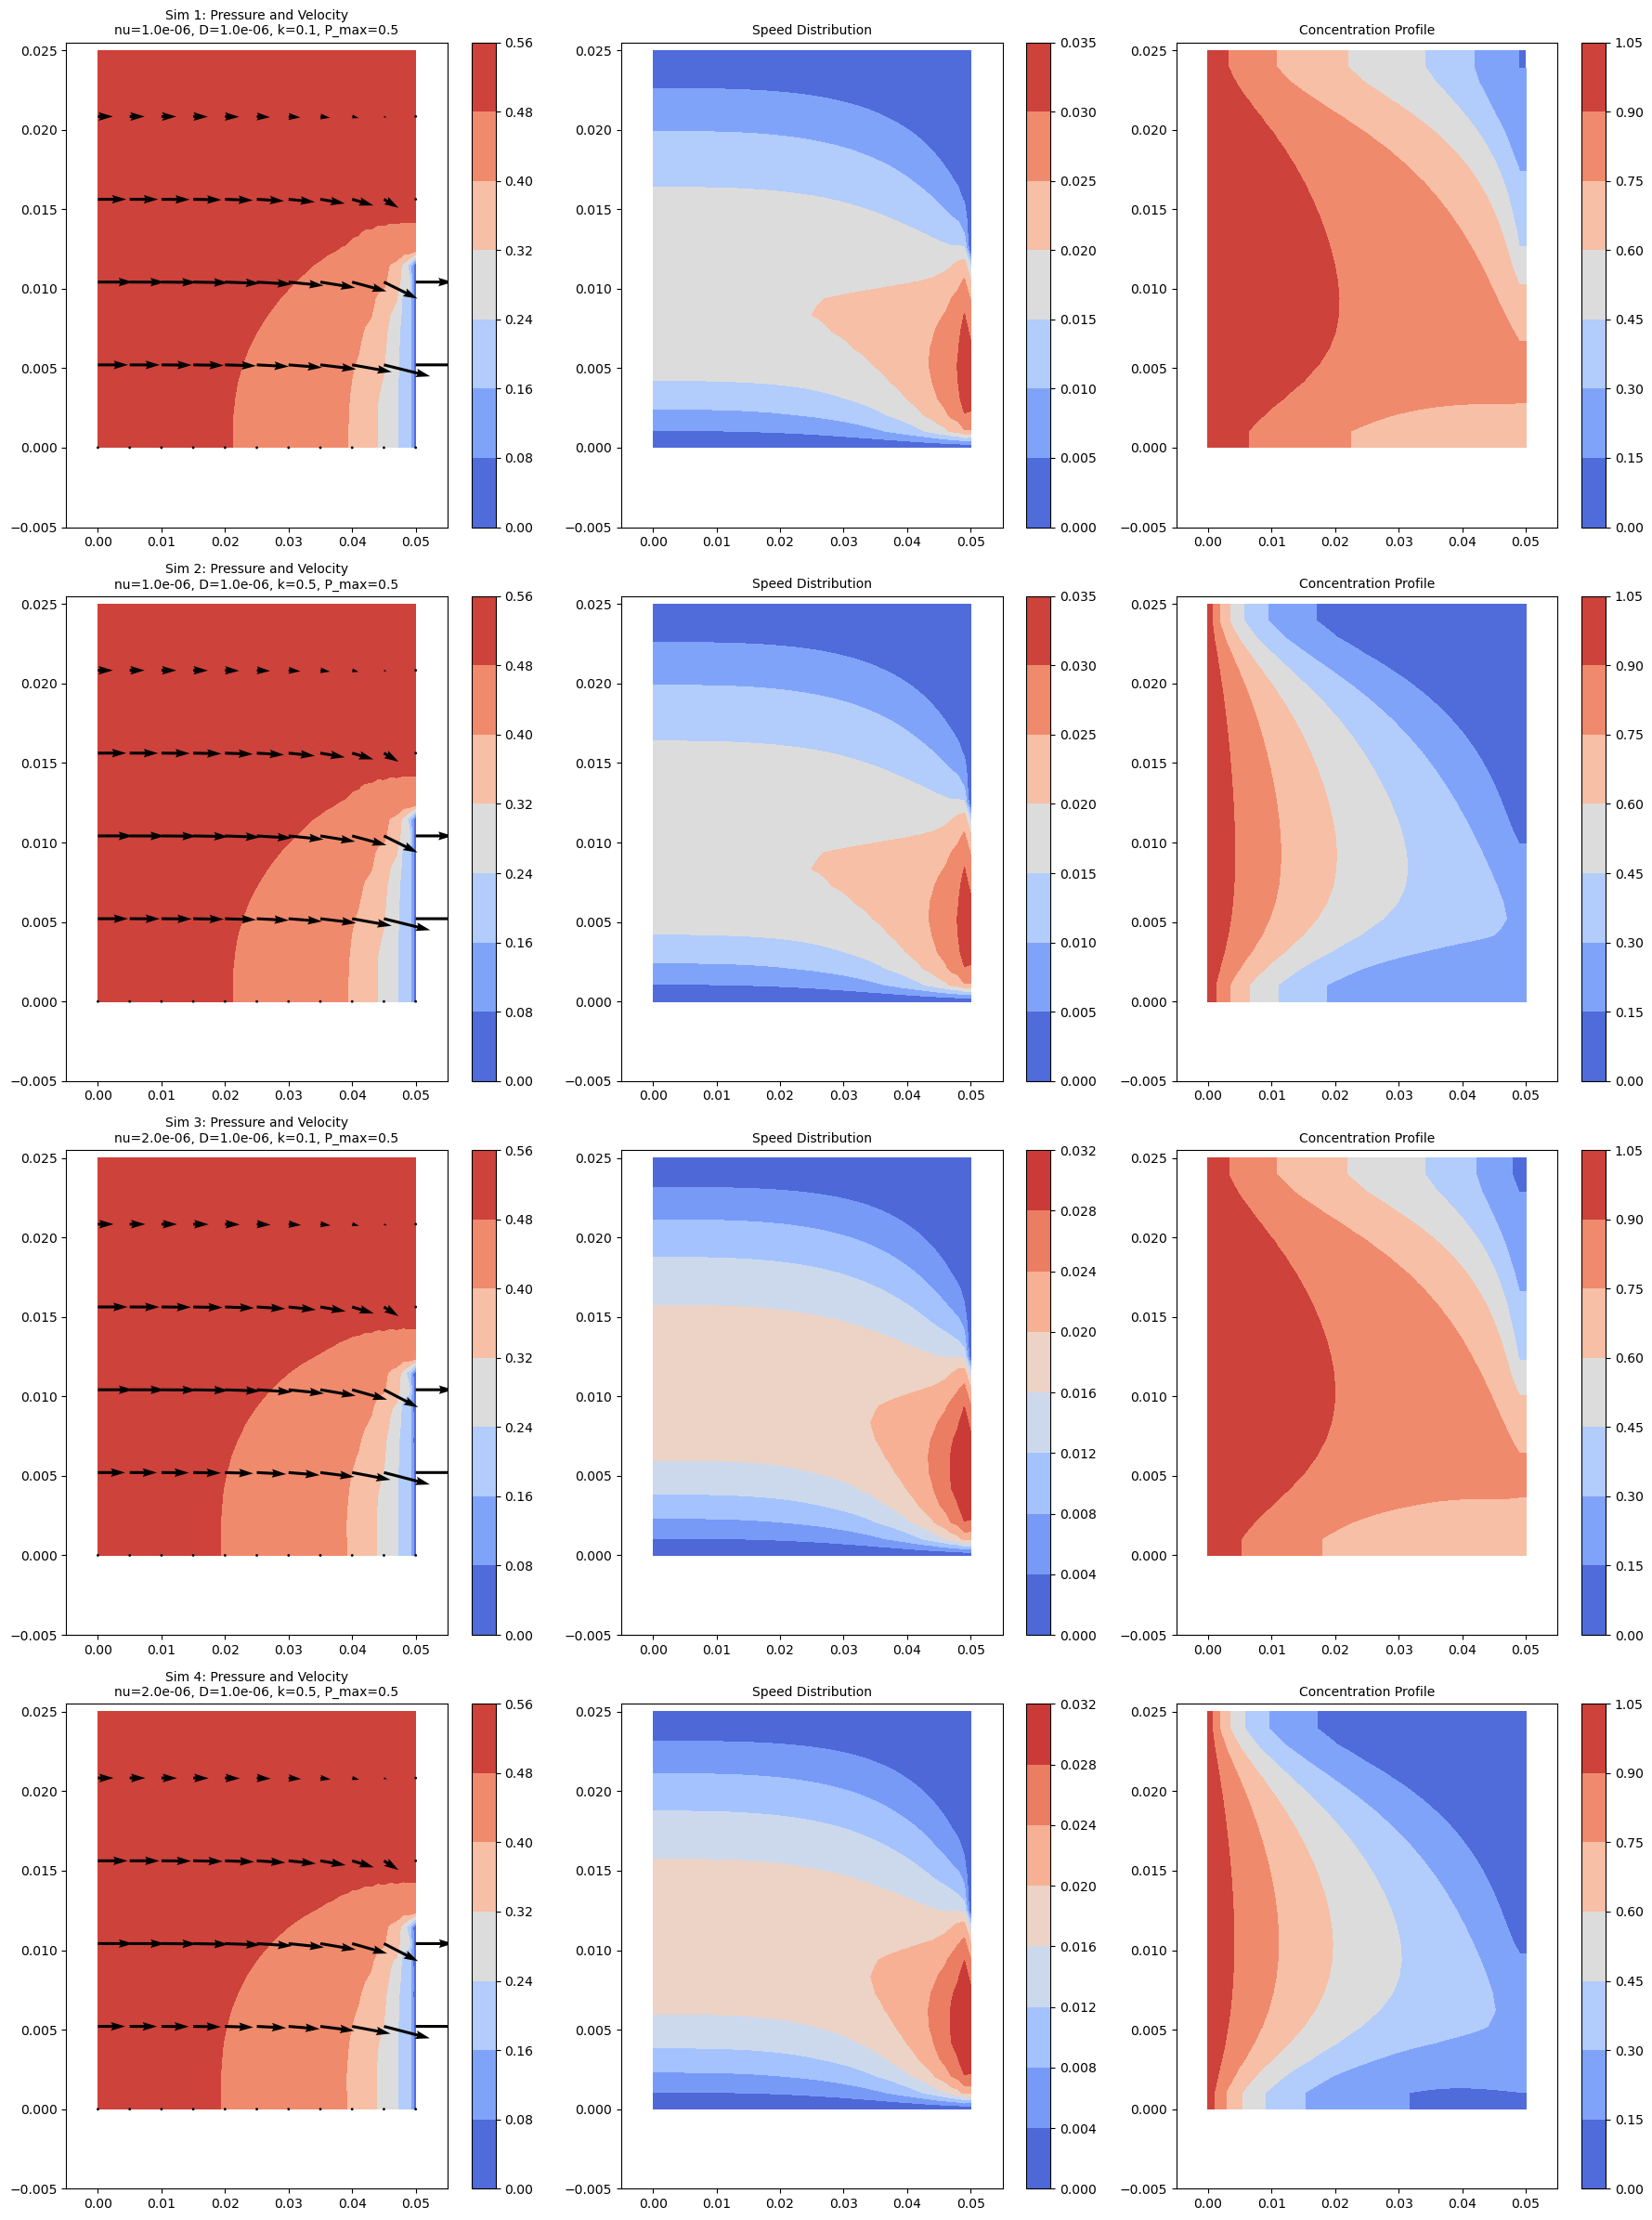

In [14]:
# Number of simulations
num_sims = len(results)

# Set up a grid for subplots: 1 row per simulation, 3 columns (pressure, speed, concentration)
fig, axes = plt.subplots(num_sims, 3, figsize=(18, 6 * num_sims))

# Loop over results and populate the subplots
for i, res in enumerate(results):
    # Retrieve stored fields
    u = res['u']
    v = res['v']
    p = res['p']
    C = res['C']

    # Retrieve simulation parameters
    nu = res['nu']
    D = res['D']
    k = res['k']
    P_max = res['P_max']

    # Subplot 1: Pressure and velocity vectors
    ax = axes[i, 0] if num_sims > 1 else axes[0]
    cont = ax.contourf(X, Y, p, cmap=cm.coolwarm)
    fig.colorbar(cont, ax=ax)
    ax.quiver(X[::5, ::5], Y[::5, ::5], u[::5, ::5], v[::5, ::5])
    ax.set_xlim(-0.005, 0.055)
    ax.set_ylim(-0.005, 0.0255)
    ax.set_title(f'Sim {i+1}: Pressure and Velocity\nnu={nu:.1e}, D={D:.1e}, k={k}, P_max={P_max}', fontsize=10)

    # Subplot 2: Speed
    ax = axes[i, 1] if num_sims > 1 else axes[1]
    speed = np.sqrt(u**2 + v**2)
    cont = ax.contourf(X, Y, speed, cmap=cm.coolwarm)
    fig.colorbar(cont, ax=ax)
    ax.set_xlim(-0.005, 0.055)
    ax.set_ylim(-0.005, 0.0255)
    ax.set_title('Speed Distribution', fontsize=10)

    # Subplot 3: Concentration profile
    ax = axes[i, 2] if num_sims > 1 else axes[2]
    cont = ax.contourf(X, Y, C, cmap=cm.coolwarm)
    fig.colorbar(cont, ax=ax)
    ax.set_xlim(-0.005, 0.055)
    ax.set_ylim(-0.005, 0.0255)
    ax.set_title('Concentration Profile', fontsize=10)

# Adjust layout and save the plot
fig.tight_layout()
plt.savefig('combined_simulations_plot.png', dpi=300)
plt.show()

In [12]:
M_out = 0.0
V_out = 0.0
for j in range(0,jmax//2):
    M_out += u[-1,j] * C[-1,j] * dy
    V_out += u[-1,j] * dy
    
C_out = M_out/V_out

print('Average outlet concentration = ', C_out)

Average outlet concentration =  0.34237836800705795


### Analysis of Results

The results provide valuable insights into the effects of physical and dimensionless parameters on the system's behavior. Below is a detailed analysis of the key findings:

---

#### **Outflow Concentration vs Reynolds Number ($Re$)**
- **Observations**:
  - As $Re$ increases, the average outflow concentration ($C_{\text{out}}$) decreases.
  - Higher $Re$ corresponds to faster flow, reducing the residence time for reactions and enhancing pollutant transport to the outlet.
  - For a fixed $P_{\text{max}}$, increasing the reaction rate ($k$) reduces $C_{\text{out}}$, highlighting the impact of the reaction kinetics.

- **Formula**:
  The Reynolds number is defined as:
  $$
  Re = \frac{\rho U L}{\mu},
  $$
  where $U$ is the average flow velocity, $L$ is the characteristic length, $\rho$ is the fluid density, and $\mu$ is the dynamic viscosity.

- **Interpretation**:
  - Faster flow (higher $Re$) reduces the pollutant's residence time in the reactor, leading to lower decay via reactions.
  - Higher $k$ reduces $C_{\text{out}}$, as faster reaction rates lead to more pollutant degradation.

---
### **Outflow Concentration vs Peclet Number ($Pe$)**

#### **Observations**:
- The outflow concentration is strongly influenced by the Peclet number, which quantifies the relative importance of advection to diffusion.
- At high $Pe$, advection dominates, resulting in a sharper concentration gradient and minimal mixing.
- At low $Pe$, diffusion dominates, leading to more uniform concentration profiles and increased mixing.

#### **Formula**:
The Peclet number is defined as:
$$
Pe = \frac{U L}{D},
$$
where:
- $U$ is the average flow velocity,
- $L$ is the characteristic length,
- $D$ is the diffusion coefficient.

#### **Interpretation**:
- **High $Pe$**:
  - Transport is advection-dominated, meaning pollutants are carried downstream with little spreading due to diffusion.
  - This often results in higher outflow concentrations as diffusion is insufficient to spread and dilute the pollutant.
- **Low $Pe$**:
  - Diffusion becomes significant, leading to broader spreading of the pollutant and lower outflow concentrations at the outlet.
  - This regime is common in slower flows or when the diffusion coefficient is large.

---

#### **Outflow Concentration vs Damköhler Number ($Da$)**
- **Observations**:
  - The outflow concentration decreases as $Da$ increases, indicating that faster reaction rates or slower flows result in more pollutant decay.
  - A higher $P_{\text{max}}$ (leading to faster flow) reduces the effect of $Da$ because advection dominates over reactions.

- **Formula**:
  The Damköhler number is given by:
  $$
  Da = \frac{k L}{U},
  $$
  where $k$ is the reaction rate, $L$ is the characteristic length, and $U$ is the average flow velocity.

- **Interpretation**:
  - A high $Da$ corresponds to a system dominated by reaction kinetics, leading to significant pollutant decay before reaching the outlet.
  - Conversely, lower $Da$ (due to high velocity or low reaction rate) leads to advection-dominated transport, reducing the pollutant decay.

---



#### **Outflow Velocity vs Reynolds Number ($Re$)**
- **Observations**:
  - The outflow velocity increases with $Re$, as expected, since $Re$ directly scales with the flow velocity.
  - Variations in $k$ and $P_{\text{max}}$ do not significantly affect the velocity trends, suggesting that the flow is primarily governed by the pressure gradient and viscosity.

- **Formula**:
  As previously defined:
  $$
  Re = \frac{\rho U L}{\mu}.
  $$

- **Interpretation**:
  - The relationship between $Re$ and velocity is linear for laminar flow, as $Re$ scales directly with the pressure gradient ($P_{\text{max}}$) and inversely with viscosity ($\mu$).
  - Reaction effects ($k$) do not influence the velocity field, as the fluid flow is decoupled from pollutant kinetics.

---

### General Insights
1. **Reynolds Number ($Re$)**:
   - Higher $Re$ leads to faster flow, reducing pollutant residence time and reaction effects. This results in lower $C_{\text{out}}$ but higher outlet velocity.

2. **Damköhler Number ($Da$)**:
   - Higher $Da$ indicates reaction-dominated systems, leading to significant pollutant decay and reduced $C_{\text{out}}$.

3. **Péclet Number ($Pe$)**:
   - Higher $Pe$ reflects advection-dominated transport, which increases velocity and reduces mixing effects.

